# Multiclass Classification using FRUITS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from context import fruits
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use(['dark_background'])

np.random.seed(1234)

## Create random time series data
We will generate $m$ time series (in $\mathbb{R}^n$).

In [2]:
# define general model function as linear concatination of sine functions
def multisine(x, coeff):
    return sum([coeff[i, 0]*np.sin(coeff[i, 1]*x+coeff[i, 2])
                for i in range(3)])

In [3]:
num_classes = 20
instances = [200 for i in range(num_classes)]
n = 100
m = sum(instances)

x_range = np.linspace(0, 2*np.pi, num=n)
rand_coeff = 2*np.random.rand(num_classes, 3, 3)
rand_coeff[0, :, :] = [[2/5, 3, 0.12], [1/4, 1/2, 0], [1, 3/2, 4]]
# print(rand_coeff)
models = [np.vectorize(lambda x: multisine(x, rand_coeff[i]))(x_range) 
          for i in range(num_classes)]
X = np.zeros((m, n))
y = np.zeros(m)
s = 0
for i, n_i in enumerate(instances):
    for j in range(n_i):
        X[s+j, :] = models[i] + np.random.normal(loc=0, scale=0.1, size=n)
        y[s+j] = i
    s += n_i
    
print(f"Shape of X: {X.shape}")

Shape of X: (4000, 100)


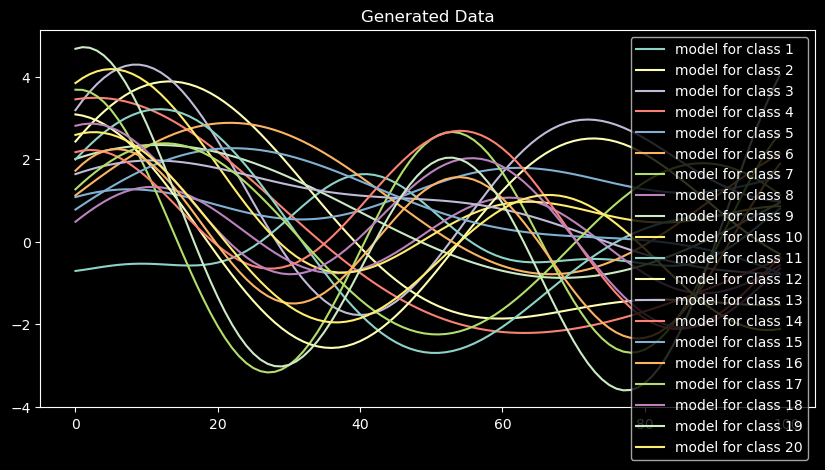

In [4]:
fig, ax = plt.subplots()
ax.set_title("Generated Data")
examples_per_class = 0
for i in range(num_classes):
    ax.plot(models[i], label=f"model for class {i+1}")
    for j in range(examples_per_class):
        ax.plot(X[y==i][j], label=f"class {i+1} example {j+1}")
ax.legend(loc="upper right")
plt.show()

In [5]:
apple = fruits.Fruit()

# re-aranging these preparateurs lead to funny changes in the plots below
apple.add(fruits.preparateurs.INC, fruits.preparateurs.STD)

words = fruits.iterators.generate_words(1, 3, 4)
apple.add(words)

# in this case, it seems that 2 features have the same impact (on the classifier)
#  as 33 iterators (18 vs. 117 features)
# so generate_words(1, 3, 3) and PPV yield approx the same result as
#  generate_words(1, 2, 2) and PPV, MAX, MIN
feature_filters = [fruits.features.PPV(quantile=0.5),
                   fruits.features.MAX,
                   fruits.features.MIN]
apple.add(feature_filters)

print("Number of features per time series: ", apple.nfeatures())
print("Used iterators: ")
print("\n".join(map(str, words)))

Created SimpleWord([1])
Created SimpleWord([11])
Created SimpleWord([111])
Created SimpleWord([1][1])
Created SimpleWord([1][11])
Created SimpleWord([1][111])
Created SimpleWord([11][1])
Created SimpleWord([11][11])
Created SimpleWord([11][111])
Created SimpleWord([111][1])
Created SimpleWord([111][11])
Created SimpleWord([111][111])
Created SimpleWord([1][1][1])
Created SimpleWord([1][1][11])
Created SimpleWord([1][1][111])
Created SimpleWord([1][11][1])
Created SimpleWord([1][11][11])
Created SimpleWord([1][11][111])
Created SimpleWord([1][111][1])
Created SimpleWord([1][111][11])
Created SimpleWord([1][111][111])
Created SimpleWord([11][1][1])
Created SimpleWord([11][1][11])
Created SimpleWord([11][1][111])
Created SimpleWord([11][11][1])
Created SimpleWord([11][11][11])
Created SimpleWord([11][11][111])
Created SimpleWord([11][111][1])
Created SimpleWord([11][111][11])
Created SimpleWord([11][111][111])
Created SimpleWord([111][1][1])
Created SimpleWord([111][1][11])
Created Simple

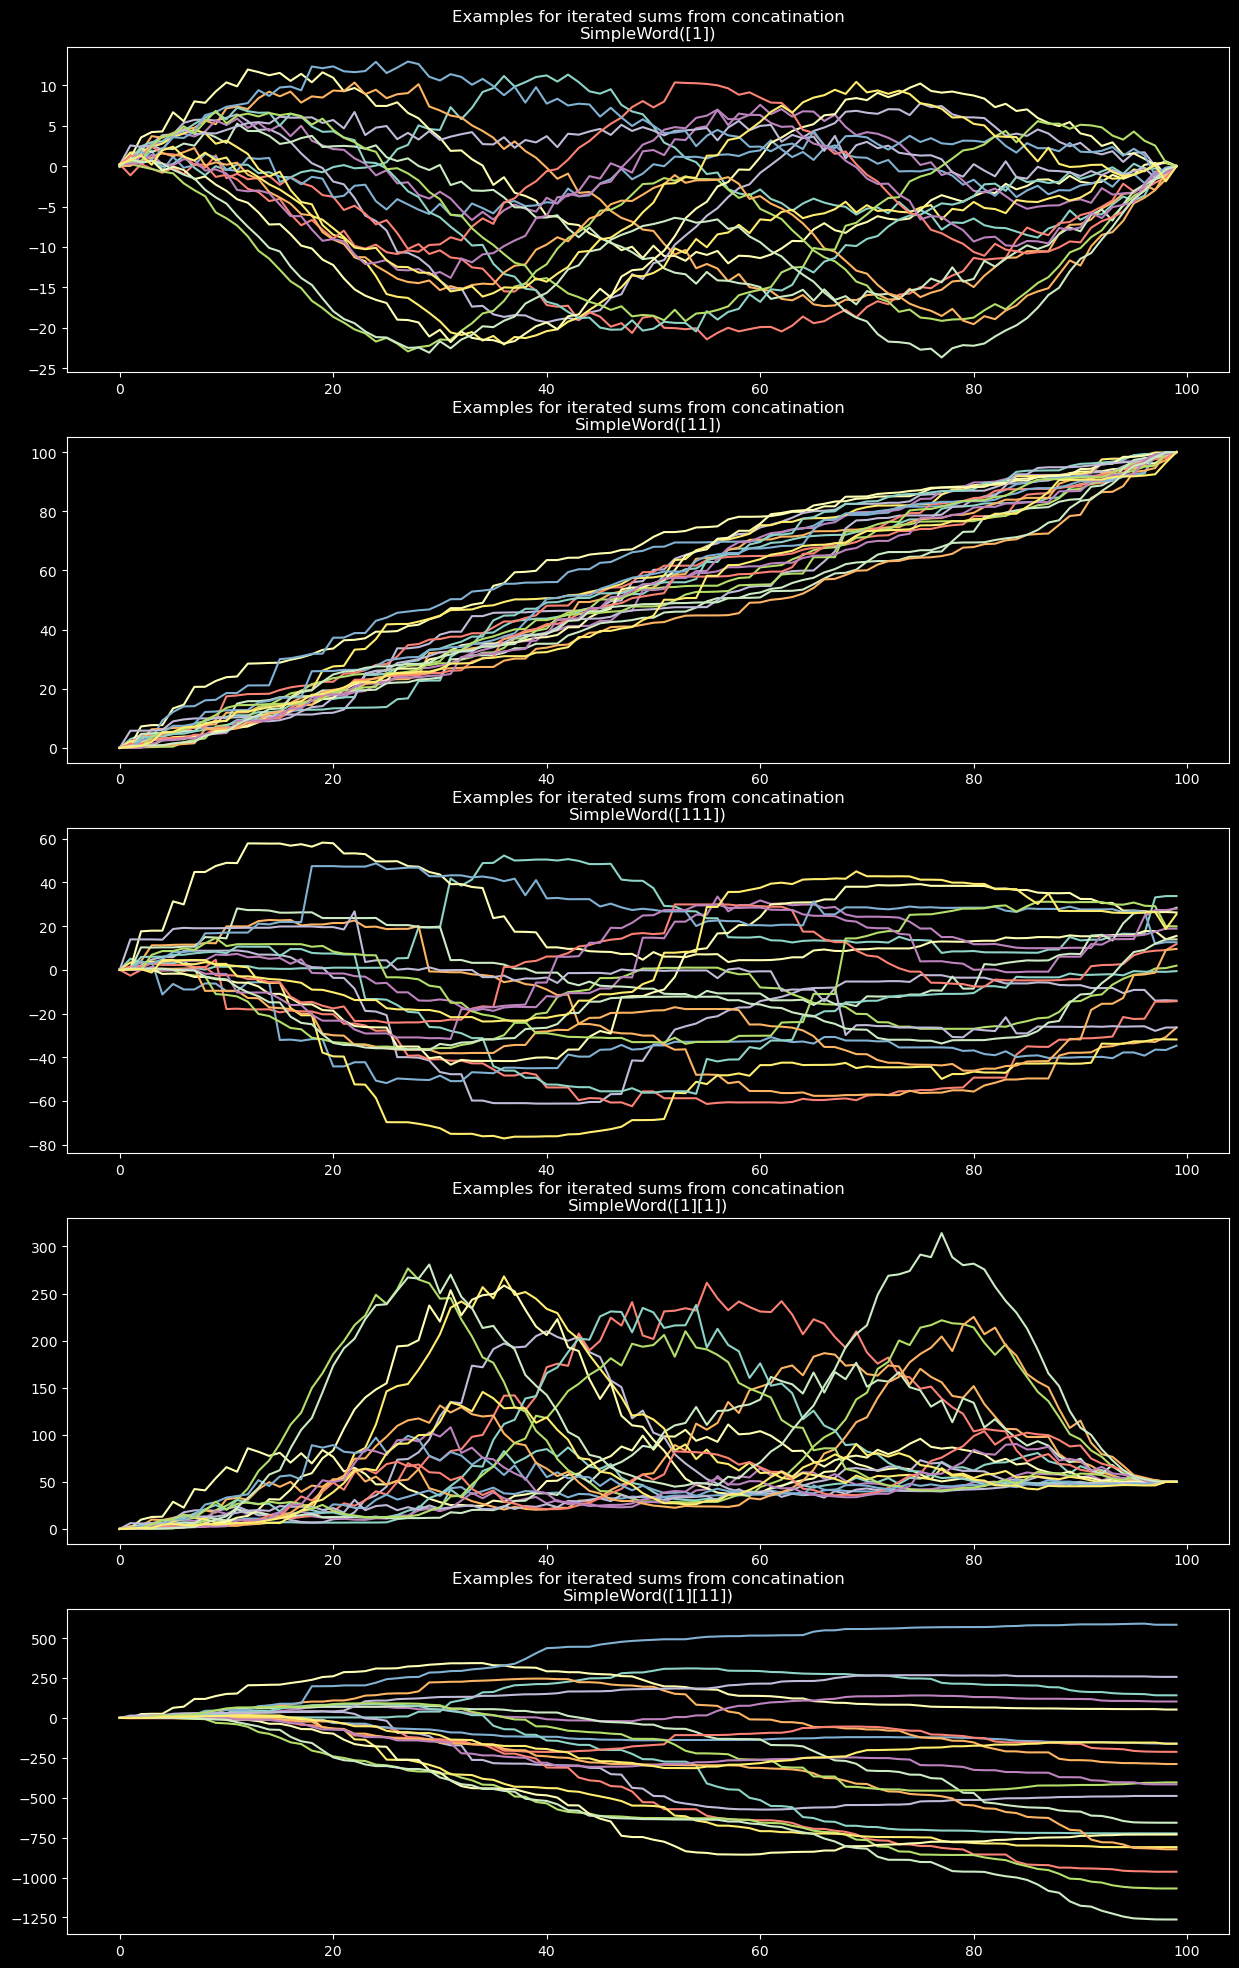

In [6]:
num_concatenations = 5
apple.set_input_data(X)
X_iter = apple.iterated_sums()
fig, axs = plt.subplots(num_concatenations, 1, figsize=(15, 5*num_concatenations))
examples_per_class = 1
for k in range(num_concatenations):
    for i in range(num_classes):
        for j in range(examples_per_class):
            axs[k].set_title(f"Examples for iterated sums from concatination\n{words[k]}")
            axs[k].plot(X_iter[y==i][j, k], label=f"class {i+1} example {j+1}")
plt.show()

In [7]:
# can take a few seconds
X_feat = apple(X)
X_feat.shape

(4000, 360)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)

In [9]:
classifier = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10), normalize = True).fit(X_train, y_train)

In [10]:
classifier.score(X_test, y_test)

0.9975

In many experiments, the number of iterators added to our apple model correlate directly with the accuracy of our classifier.

In [11]:
y_test_pred = classifier.predict(X_test)

In [12]:
sum(y_test_pred!=y_test)

2